In [1]:
%pip install osmnx
%pip install mapclassify
%pip install geopy
%pip install alphashape
%pip install contextily

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [5]:
from os import mkdir

# Mount Google Drive
%google-drive-ocamlfuse
%mkdir -p ~/GoogleDrive
%google-drive-ocamlfuse ~/GoogleDrive

UsageError: Line magic function `%google-drive-ocamlfuse` not found.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import geopandas as gpd
import contextily as ctx
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import mapclassify
import folium
import matplotlib
import geopy.distance
import numpy as np
from shapely.geometry import Point, MultiPoint
from shapely.ops import unary_union
import geemap
import geopandas as gpd
import shapely.wkt
from alphashape import alphashape
from shapely.geometry import shape, Polygon, MultiPolygon, GeometryCollection, MultiPoint, Point

Mounted at /content/drive


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")

# Straßennetzwerke direkt über Stadtname laden

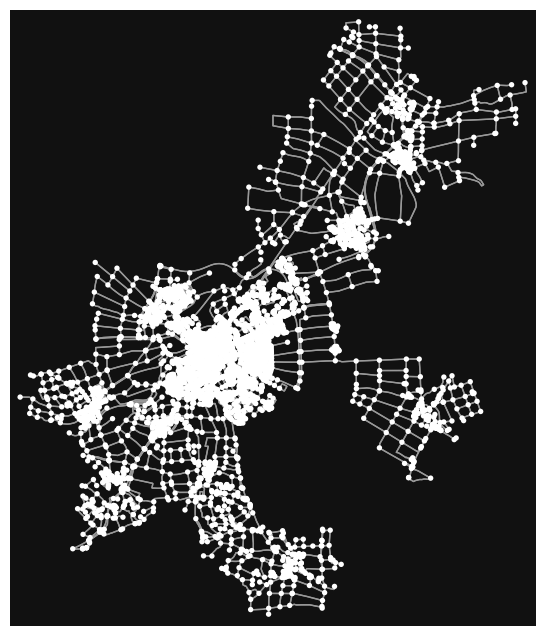

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G_Noerdlingen = ox.graph_from_place('Noerdlingen, Germany', network_type='walk')
ox.plot_graph(G_Noerdlingen)

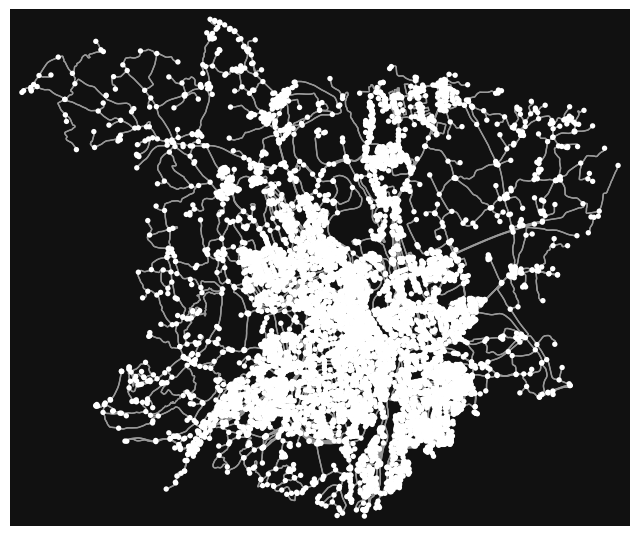

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G_Kempten = ox.graph_from_place('Kempten, Germany', network_type='walk')
ox.plot_graph(G_Kempten)

In [ ]:
G_Ingolstadt = ox.graph_from_place('Ingolstadt, Germany', network_type='walk')
ox.plot_graph(G_Ingolstadt)

In [ ]:
# Optional: Speichern der Netzwerke im GraphML-Format
#ox.save_graphml(G_Noerdlingen, filepath='noerdlingen_strassennetz.graphml')
#ox.save_graphml(G_Kempten, filepath='kempten_strassennetz.graphml')
#ox.save_graphml(G_Ingolstadt, filepath='ingolstadt_strassennetz.graphml')

In [ ]:
G_Noerdlingen = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml')
G_Kempten = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml')
G_Ingolstadt = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml')

Cold-Spots Polygone laden

In [ ]:
# Cold Spots aus einer Datei laden (Beispiel: GeoJSON)
cold_spot_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_Polygon.geojson")
cold_spot_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_Polygon.geojson")
cold_spot_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_Polygon.geojson")


DataSourceError: /content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_Polygon.geojson: No such file or directory

In [ ]:
print(cold_spot_Ingolstadt.head(10))
print(cold_spot_Kempten.head(10))
print(cold_spot_Noerdlingen.head(10))

                                            geometry
0  MULTIPOINT (11.27363 48.76195, 11.2739 48.7616...
                                            geometry
0  MULTIPOINT (10.25144 47.71334, 10.25144 47.713...
                                            geometry
0  MULTIPOINT (10.44089 48.80938, 10.44116 48.806...


nearest nodes: Zentroid Methode nicht so sinnvoll, bringt ungenaues Ergebnis bei unsymmetrischen, langgestreckten Cold Spots

deshalb: Linienbasierte Erreichbarkeitsanalyse mit Grenze der Polygone als Ausgangslinie

# Nördlingen Service Areas

überlappende Polygone sollen als ein feature gesehen werden, und alleinstehende ebenso als eines: dafür: nach überlappungen suchen, diese dann zusammenführen und schließlich jedem Cold Spot eine Clsuter ID hinzufügen (um überlappende als Gruppe zu sehen), um schließlich die geometrien zu vereinigen

dafür vorher noch: POINTS (Cold Spots) in Polygone umwandeln => mit buffer Befehl (100m, weil Landsat Pixel auch 100m Auflösung haben)

ausgehend von den bereits gruppierten Cold Spots (dissolved_Noerdlingen) für jeden Cold Spot eine linienbasierte Erreichbarkeitsanalyse durchführen: entlang der Grenzen der Cold Spots in regelmäßigen Abständen (50 m) eine Reihe von Ausgangspunkten generieren

 Für jeden dieser Punkte wird der nächstgelegene Knoten im Fußgängernetzwerk (G_Noerdlingen) bestimmt. Anschließend wird für jeden dieser Startknoten eine Isochrone (Erreichbarkeitszone) für 5, 10 und 15 Minuten berechnet – bei einer Gehgeschwindigkeit von 1 m/s entspricht das 300, 600 bzw. 900 m. Zum Schluss werden für jeden Cold Spot die Isochronen der einzelnen Startpunkte pro Zeitlimit vereinigt.

# Service Areas für Nördlingen, Kempten und Ingolstadt

Cold Spots gruppieren, sodass überlappende als einer gesehen werden

In [ ]:
# Cold Spots aus einer Datei laden (Beispiel: GeoJSON)
cold_spot_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_Polygon.geojson")
cold_spot_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_Polygon.geojson")
cold_spot_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_Polygon.geojson")


In [ ]:
def cluster_cold_spots(gdf):
    """
    Gruppiert Cold Spots basierend auf Überschneidungen und weist Cluster-IDs zu.

    Args:
        gdf: GeoDataFrame mit Cold Spot-Geometrien.

    Returns:
        GeoDataFrame mit zusätzlicher Spalte 'cluster_id'.
    """

    # Kopie des GeoDataFrames erstellen
    gdf_clustered = gdf.copy().reset_index(drop=True)

    # Geometrien umwandeln
    gdf_clustered = gdf_clustered.to_crs(epsg=32632)

    # Explodiere MultiPolygone in einzelne Polygone und setze den Index neu
    gdf_clustered = gdf_clustered.explode(index_parts=True).reset_index(drop=True)

    # Überprüfen, ob es sich um Punkte handelt und diese in Polygone umwandeln
    if gdf_clustered.geometry.iloc[0].geom_type in ['Point', 'MultiPoint']:
        buffer_distance = 100  # 100m, weil Landsat Pixel auch 100m Auflösung haben
        print(f"Anwenden eines Buffers von {buffer_distance} Metern auf Punktgeometrien.")
        gdf_clustered['geometry'] = gdf_clustered.geometry.buffer(buffer_distance)

    # --- Aufbau des Graphen zur Cluster-Bildung ---
    G = nx.Graph()
    for idx in gdf_clustered.index:
        G.add_node(idx)

    sindex = gdf_clustered.sindex
    for idx, geom in gdf_clustered.geometry.items():
        possible_matches_index = list(sindex.intersection(geom.bounds))
        for other_idx in possible_matches_index:
            if idx < other_idx:
                # Hier wird überprüft, ob sich die Polygone überschneiden
                if geom.intersects(gdf_clustered.loc[other_idx, 'geometry']):
                    G.add_edge(idx, other_idx)

    clusters = list(nx.connected_components(G))
    print("Gefundene Cluster:", clusters)

    # Mapping: Jeder ursprüngliche Index erhält eine Cluster-ID
    cluster_mapping = {}
    for cluster_id, component in enumerate(clusters):
        for idx in component:
            cluster_mapping[idx] = cluster_id

    gdf_clustered['cluster_id'] = gdf_clustered.index.map(cluster_mapping)

    # Polygone innerhalb des gleichen Clusters zusammenführen
    gdf_dissolved = gdf_clustered.dissolve(by='cluster_id', aggfunc='first') # 'first' behält die Attribute des ersten Features bei

    # Geometrie in Polygon oder MultiPolygon umwandeln (falls nötig)
    gdf_dissolved['geometry'] = gdf_dissolved['geometry'].apply(lambda geom: geom if isinstance(geom, (Polygon, MultiPolygon)) else geom.convex_hull)

    return gdf_dissolved

# Wende die Funktion auf die Cold Spot-Dateien an
cold_spot_Ingolstadt = cluster_cold_spots(cold_spot_Ingolstadt)
cold_spot_Kempten = cluster_cold_spots(cold_spot_Kempten)
cold_spot_Noerdlingen = cluster_cold_spots(cold_spot_Noerdlingen)

# Speichere die bearbeiteten Dateien
cold_spot_Ingolstadt.to_file("Ingolstadt_ColdSpots_clustered.geojson", driver="GeoJSON")
cold_spot_Kempten.to_file("Kempten_ColdSpots_clustered.geojson", driver="GeoJSON")
cold_spot_Noerdlingen.to_file("Noerdlingen_ColdSpots_clustered.geojson", driver="GeoJSON")

Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}]
Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}]
Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}]


geclusterte(gruppierte Cold Spots laden)

In [ ]:
cold_spots_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_clustered.geojson")
cold_spots_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_clustered.geojson")
cold_spots_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_clustered.geojson")

In [ ]:
print("Ingolstadt:")
print(cold_spots_Ingolstadt)

print("\nKempten:")
print(cold_spots_Kempten)

print("\nNördlingen:")
print(cold_spots_Noerdlingen)

Ingolstadt:
    cluster_id                                           geometry
0            0  POLYGON ((667370.175 5403263.678, 667362.293 5...
1            1  POLYGON ((668301.879 5403785.293, 668292.36 54...
2            2  POLYGON ((670421.19 5400981.927, 670412.773 54...
3            3  POLYGON ((669907.512 5402225.54, 669899.094 54...
4            4  POLYGON ((670035.183 5400537.395, 670025.381 5...
5            5  POLYGON ((670283.36 5401881.486, 670280.976 54...
6            6  POLYGON ((670367.445 5399776.561, 670358.574 5...
7            7  POLYGON ((670286.385 5400754.896, 670276.583 5...
8            8  POLYGON ((673578.57 5400141.397, 673569.33 540...
9            9  POLYGON ((674218.008 5401567.757, 674208.488 5...
10          10  POLYGON ((674557.203 5397680.562, 674547.684 5...
11          11  POLYGON ((674733.188 5400049.256, 674725.917 5...
12          12  POLYGON ((675110.537 5398055.257, 675100.735 5...
13          13  POLYGON ((677762.505 5402723.124, 677755.234 5..

umwandeln in shapefile (um in qgis zu verwenden)

In [ ]:
# Definiere den Pfad für die Ausgabedatei (Shapefile)
shapefile_Noerdlingen = "ColdSpots_Noerdlingen.shp"
shapefile_Kempten = "ColdSpots_Kempten.shp"
shapefile_Ingolstadt = "ColdSpots_Ingolstadt.shp"

# Geojson Dateien lesen
Kempten_gdf = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_clustered.geojson")
Ingolstadt_gdf = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_clustered.geojson")
Noerdlingen_gdf = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_clustered.geojson")

# Funktion zum Zuweisen und Umwandeln der Geometriespalte
def assign_and_convert_geometry(gdf):
    """Weist die Geometriespalte zu und konvertiert sie in den richtigen Geometrietyp."""
    gdf.geometry = gdf.geometry.apply(lambda geom: geom if isinstance(geom, (Polygon, MultiPolygon)) else geom.convex_hull)
    gdf.geometry = gpd.GeoSeries(gdf.geometry, crs=gdf.crs)
    gdf = gpd.GeoDataFrame(gdf[['cluster_id', 'geometry']], geometry='geometry', crs=gdf.crs) # 'geometry' und 'cold_spot_id' durch die tatsächlichen Spaltennamen ersetzen, falls abweichend
    gdf = gdf.reset_index(drop=True)
    return gdf

# Anwendung der Funktion und Schreiben in Shapefiles
Noerdlingen_gdf = assign_and_convert_geometry(Noerdlingen_gdf)
Noerdlingen_gdf.to_file(shapefile_Noerdlingen, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Noerdlingen.geojson", driver="GeoJSON")

Kempten_gdf = assign_and_convert_geometry(Kempten_gdf)
Kempten_gdf.to_file(shapefile_Kempten, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Kemoten.geojson", driver="GeoJSON")

Ingolstadt_gdf = assign_and_convert_geometry(Ingolstadt_gdf)
Ingolstadt_gdf.to_file(shapefile_Ingolstadt, driver="ESRI Shapefile")
Noerdlingen_gdf.to_file("ColdSpots_Ingolstadt.geojson", driver="GeoJSON")

print(f"GeoJSON-Dateien erfolgreich in Shapefiles konvertiert.")


GeoJSON-Dateien erfolgreich in Shapefiles konvertiert.


funktioniert nicxht :( attributtabelle von shapefile (auch von geojson) zeigt geometry spalte nicht an, obwohl datentyp stimmt...

# Visualisieren

vergleich von mit und ohne eingezeichnete Cold Spots zeigt, dass Zentroid als Startpunkte nicht ausreichen, viele Bereiche die eigtl in Erreichbarkeitszone liegen müsstne werden dann nicht angezeigt =>
Berechnung finden, die Erreichbarkeit von den **Außengrenzen der Cold Spots** berechnet



Punkte im Abstand von x (hier 5) Metern an Außenlinie der Polygone gelten als Startpunkte => nearest nodes => Erreichbarkeit 5, 10, 15 Minuten

In [ ]:
import pickle

--- Verarbeitung von Noerdlingen ---
--- Noerdlingen abgeschlossen ---


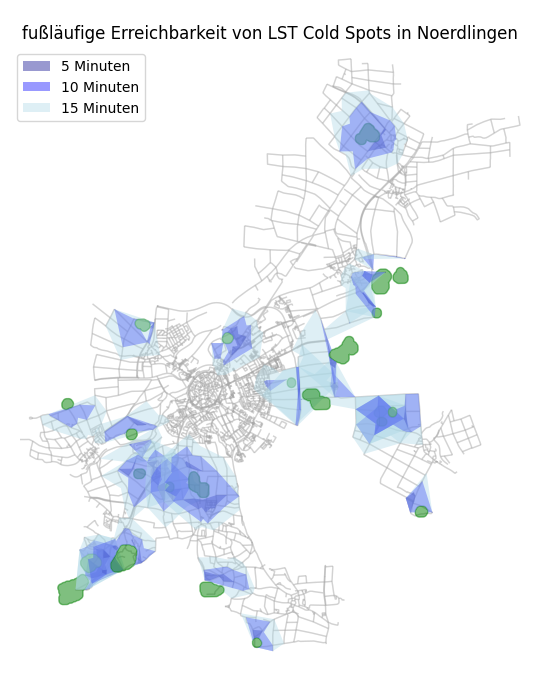

--- Verarbeitung von Kempten ---
--- Kempten abgeschlossen ---


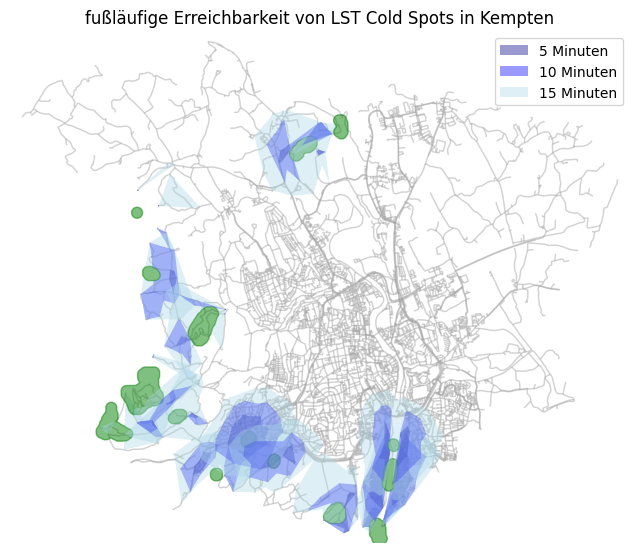

--- Verarbeitung von Ingolstadt ---
--- Ingolstadt abgeschlossen ---


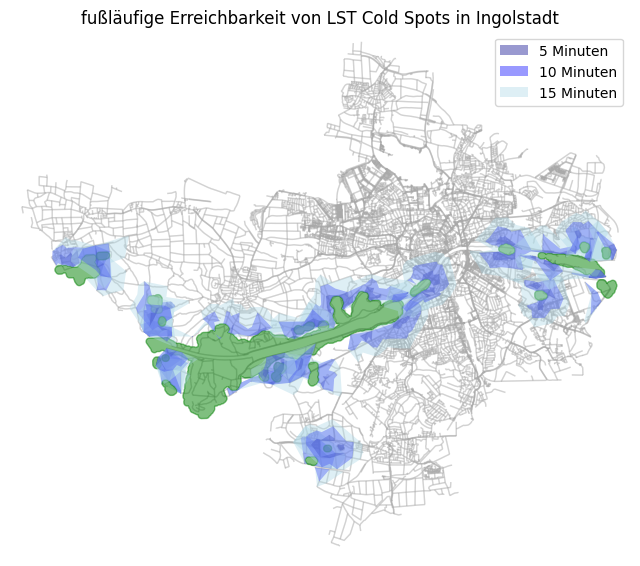

In [ ]:
# Parameter festlegen
walk_speed = 1  # Gehgeschwindigkeit in m/s (entspricht ca. 5 km/h)
time_thresholds = [300, 600, 900]  # 5, 10 und 15 Minuten in Sekunden
colors = {300: 'darkblue', 600: 'blue', 900: 'lightblue'}
point_interval = 5  # Abstand der Punkte entlang der Außenlinie in Metern


def sample_points_on_line(line, interval):
    """Erzeugt Punkte entlang einer LineString-Geometrie in regelmäßigen Abständen."""
    distances = np.arange(0, line.length, interval)
    points = [line.interpolate(distance) for distance in distances]
    return points


# Schleife über die Städte und Cold Spots
for stadt, cold_spot_data, graph in [("Noerdlingen", cold_spot_Noerdlingen, G_Noerdlingen),
                                    ("Kempten", cold_spot_Kempten, G_Kempten),
                                    ("Ingolstadt", cold_spot_Ingolstadt, G_Ingolstadt)]:
    print(f"--- Verarbeitung von {stadt} ---")

    # Projiziere den Graphen in UTM Zone 32N
    graph_proj = ox.project_graph(graph, to_crs='epsg:32632')

    # Füge die 'travel_time' Attribut zu den Kanten hinzu
    for u, v, key, data in graph_proj.edges(keys=True, data=True):
        data['travel_time'] = data.get('length', 0) / walk_speed

    # Projiziere den Cold Spot GeoDataFrame in die gleiche Projektion wie der Graph
    cold_spot_data_proj = cold_spot_data.to_crs(graph_proj.graph['crs'])

    # --- Hier wird der results-Dictionary initialisiert ---
    results = []

    # Erstelle eine Figure und ein Axes-Objekt vor der Schleife
    fig, ax = ox.plot_graph(graph_proj, show=False, close=False, node_size=0,
                           edge_color='darkgray', edge_alpha=0.3, bgcolor='white')

    # Legende-Handles und Labels - Initialisieren Sie sie hier, aber fügen Sie sie später hinzu
    legend_handles = []
    legend_labels = []

    # Schleife über alle Cold Spots der Stadt
    for idx, row in cold_spot_data_proj.iterrows():
        cold_spot_polygon = row.geometry

        # Zeichne den Cold Spot als Polygon
        x, y = cold_spot_polygon.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='green', ec='green', label="Cold Spot")  # Zeichne Cold Spot hier

        # Erzeuge Punkte entlang der Außenlinie des Cold Spots
        boundary_line = cold_spot_polygon.boundary
        boundary_points = sample_points_on_line(boundary_line, point_interval)

        # Isochronen für jedes Zeitlimit speichern
        isochrones_per_threshold = {thresh: [] for thresh in time_thresholds}

        # Berechne die Erreichbarkeiten von den Punkten entlang der Außenlinie
        for point in boundary_points:
            # Finde den nächstgelegenen Knoten zum Punkt
            nearest_node = ox.distance.nearest_nodes(graph_proj, X=point.x, Y=point.y)

            # Berechne die Isochronen für die Zeitlimits, aber nur außerhalb des Cold Spots
            for time_limit in time_thresholds:
                subgraph = nx.ego_graph(graph_proj, nearest_node, radius=time_limit, distance='travel_time')
                node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)
                               if not cold_spot_polygon.contains(Point(data['x'], data['y']))]  # Nur Punkte außerhalb

                # Wenn weniger als 3 Punkte erreichbar sind, verwende den nächstgelegenen Knotenpunkt
                if len(node_points) < 3:
                    polygon = Point(graph_proj.nodes[nearest_node]['x'], graph_proj.nodes[nearest_node]['y']).buffer(10)
                    polygon = polygon.difference(cold_spot_polygon)  # Überlappenden Bereich entfernen
                else:
                    polygon = unary_union(node_points).convex_hull
                    polygon = polygon.difference(cold_spot_polygon)  # Überlappenden Bereich entfernen

                isochrones_per_threshold[time_limit].append(polygon)  # Isochrone speichern

       # --- Hier wird das Ergebnis an den results-Dictionary angehängt ---
        results.append({
            'cold_spot_id': idx,
            'geometry': cold_spot_polygon,  # Originalgeometrie des Cold Spots
            'service_5min': unary_union(isochrones_per_threshold[300]) if isochrones_per_threshold[300] else None,
            'service_10min': unary_union(isochrones_per_threshold[600]) if isochrones_per_threshold[600] else None,
            'service_15min': unary_union(isochrones_per_threshold[900]) if isochrones_per_threshold[900] else None
        })

        # Isochronen für jedes Zeitlimit zusammenführen und zeichnen
        for time_limit in time_thresholds:
            # Alle Isochronen für dieses Zeitlimit zu einer einzigen Geometrie zusammenführen
            merged_isochrone = unary_union(isochrones_per_threshold[time_limit])

            # Zeichne die zusammengeführte Isochrone, berücksichtige MultiPolygon
            if merged_isochrone.geom_type == 'Polygon':
                x, y = merged_isochrone.exterior.xy
                handle = ax.fill(x, y, alpha=0.4, fc=colors[time_limit], ec='none')  # Now using ax from outer scope
            elif merged_isochrone.geom_type == 'MultiPolygon':
                for polygon in merged_isochrone.geoms:  # Iteriere durch die Polygone im MultiPolygon
                    x, y = polygon.exterior.xy
                    handle = ax.fill(x, y, alpha=0.4, fc=colors[time_limit], ec='none')  # Now using ax from outer scope
            else:
                # Handle other geometry types if necessary
                pass

            # Füge Handle und Label zur Legende hinzu (nur einmal pro Zeitlimit)
            label = f'{time_limit / 60:.0f} Minuten'
            if label not in legend_labels:
                legend_handles.append(handle[0])  # Assuming handle is a list
                legend_labels.append(label)


    # --- Speichern des results-Dictionarys als Pickle-Datei ---
    with open(f'service_area_results_{stadt}.pickle', 'wb') as f:
        pickle.dump(results, f)

    # --- Erstellen und Speichern des GeoDataFrames ---
    service_area_gdf = gpd.GeoDataFrame(results, crs=cold_spot_data_proj.crs)
    service_area_gdf.to_file(f"service_area_gdf_{stadt}.geojson", driver="GeoJSON")

    print(f"--- {stadt} abgeschlossen ---")

    # Setze den Titel und die Legende für den Plot - außerhalb der Schleife
    ax.set_title(f"fußläufige Erreichbarkeit von LST Cold Spots in {stadt}")
    ax.legend(handles=legend_handles, labels=legend_labels)
    plt.show()  # Zeige den Plot außerhalb der Schleife

graph ml Datei aufbereiten für QGIS


In [ ]:
%pip install -U osmnx

In [ ]:

# Graph aus der GraphML-Datei laden
G_Noerdlingen = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/noerdlingen_strassennetz.graphml')
G_Kempten = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/kempten_strassennetz.graphml')
G_Ingolstadt = ox.load_graphml('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/OSMnx/ingolstadt_strassennetz.graphml')


# save graph as a geopackage
ox.io.save_graph_geopackage(G_Noerdlingen, filepath="Wegenetz_Noerdlingen.gpkg")
ox.io.save_graph_geopackage(G_Kempten, filepath="Wegenetz_Kempten.gpkg")
ox.io.save_graph_geopackage(G_Ingolstadt, filepath="Wegenetz_Ingolstadt.gpkg")